Import relevant packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

tf.enable_eager_execution()
#tf.compat.v1.set_random_seed(18)

/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Set up data loading functions.

In [2]:
tf.__version__

'1.14.0'

In [3]:
# One shot learning - Each network takes input and output and tries to compare if two tasks are the same.
Xt = []
Yt = []
Xv = []
Yv = []

rng = np.random.default_rng()

def load(name, training):
    with open(name) as json_file:
        data = json.load(json_file) 
        ctask = []
        for t in data['train']:
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cX = np.concatenate((cinr, coutr))
            ctask.append(cX)
            if training:
                Yt.append(name)
            else:
                Yv.append(name)
        if training:
            Xt.append(np.array(ctask))
        else:
            Xv.append(np.array(ctask))

def testAccuracy(model, N, loops, training):
    if training:
        X = Xt
        Y = Yt
    else:
        X = Xv
        Y = Yv
    right = 0
    wrong = 0
    for _ in range(loops):
        basecategory = random.randint(0, X.shape[0]-1)
        baseTask = X[basecategory][0].reshape(60, 30, 1)
        baseProb = model.predict([np.array([baseTask]), np.array([X[basecategory][random.randint(1, X[basecategory].shape[0]-1)].reshape(60, 30, 1)])])[0][0]
        for i in range(0, N):
            ccategory = (basecategory+random.randint(1, X.shape[0]))%X.shape[0]
            cindex = random.randint(0, X[ccategory].shape[0]-1)
            ctask = X[ccategory][cindex] 
            cProb = model.predict([np.array([baseTask]), np.array([ctask.reshape(60, 30, 1)])])
            if cProb[0][0] > baseProb:
                wrong += 1
                break
        else:
            right += 1
    return (100*right)/loops

def getBatch(batchsize, training):
    if training:
        X = Xt
        Y = Yt
    else:
        X = Xv
        Y = Yv
    categories = rng.choice(X.shape[0], size=(batchsize,), replace=False)
    targets = np.zeros((batchsize,))
    targets[batchsize//2:] = 1
    pairs=[np.zeros((batchsize, 60, 30, 1)) for i in range(2)]
    for i in range(batchsize):
        category = categories[i]
        pairs[0][i,:,:,:] = X[category][random.randint(0, X[category].shape[0]-1)].reshape(60, 30, 1)
        if i >= batchsize // 2:
            category_2 = category
        else:
            category_2 = (category + random.randint(1, X.shape[0])) % X.shape[0] 
        pairs[1][i,:,:,:] = X[category_2][random.randint(0, X[category_2].shape[0]-1)].reshape(60, 30, 1)
    return pairs, targets

def generate(batchsize, training):
    while True:
        pairs, targets = getBatch(batchsize, training)
        yield (pairs, targets)

Load data.

In [4]:
with os.scandir('training/') as entries:
    for entry in entries:
        load("training/"+entry.name, True)

with os.scandir('test/') as entries:
    for entry in entries:
        load("test/"+entry.name, False)

Xt = np.array(Xt)
Xv = np.array(Xv)
Yt = np.array(Yt)
Yv = np.array(Yv)

Define model.

In [8]:
# This function is based off the example in this tutorial: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (10,10), padding="same", activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096*2, activation='sigmoid'))

    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

Train model.

In [9]:
model = get_siamese_model((60, 30, 1))
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)
print(testAccuracy(model, 10, 18, False))

bestAccuracy = 0

for i in range(100):
    model.fit_generator(generate(128, True), epochs=1, steps_per_epoch=50)
    accuracy = testAccuracy(model, 20, 18, False)
    if accuracy > bestAccuracy:
        model.save_weights("bestCheckpoint/best")
        bestAccuracy = accuracy
        print("New Best: "+str(bestAccuracy))

11.11111111111111
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

Adversarial Generation.

In [10]:
#sampletask = [np.array([AI.Xt[0][0].reshape(60,30,1)]), np.array([AI.Xt[1][1].reshape(60,30,1)])]
loss_object = tf.keras.losses.BinaryCrossentropy()
def getGradients(taskin, cmodel):
    taskin[0] = tf.convert_to_tensor(taskin[0].astype(np.float32))
    taskin[1] = tf.convert_to_tensor(taskin[1].astype(np.float32))
    with tf.GradientTape() as tape:
        tape.watch(taskin)
        prediction = cmodel(taskin)
        loss = loss_object(tf.convert_to_tensor(np.array([1]).reshape(1, 1)), prediction)
    gradient = tape.gradient(loss, taskin)
    #signs = tf.sign(gradient)
    return [gradient[1].numpy()[0][30:], loss]

def generateTask(examples, cin, l, epochs, cmodel):
    cin = cin.astype(np.float64)
    for i in range(epochs):
        grads = np.zeros((30, 30, 1))
        err = 0
        for e in examples:
            sampletask = [np.array([e]), np.array([cin.reshape(60,30,1)])] 
            result = getGradients(sampletask, cmodel)
            grads += result[0]
            err += result[1].numpy()
        grads /= len(examples)
        err /= len(examples)
        grads *= l
        adjustment = np.zeros((60,30,1))
        adjustment[30:, :, :] = grads
        cin -= adjustment
        np.clip(cin, -1, 9, out=cin)
        if i%200 == 0:
            print("EPOCH "+str(i)+": "+str(err))
        if i%500 == 0:
            out = cin.reshape(60, 30)[30:, :]
            plt.imshow(out)
            plt.colorbar()
            plt.show()
    return out


In [11]:
import matplotlib.pyplot as plt
model = get_siamese_model((60, 30, 1))
model.load_weights("bestCheckpoint/best")

3


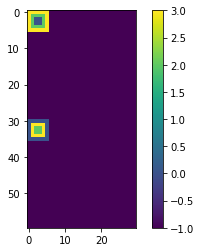

In [20]:
n = 3
print(len(Xt[n]))
plt.imshow(Xt[n][0].reshape(60, 30))
plt.colorbar()
plt.show()

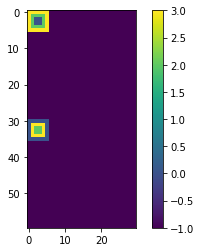

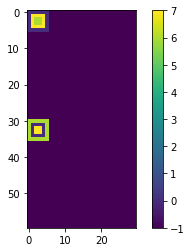

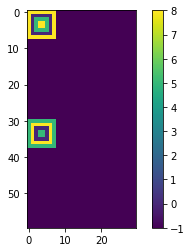

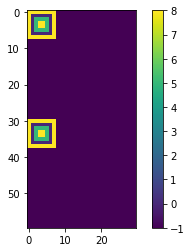

EPOCH 0: 0.02546213660389185


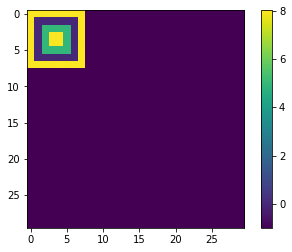

EPOCH 200: 0.002105951542034745
EPOCH 400: 0.0012545997451525182


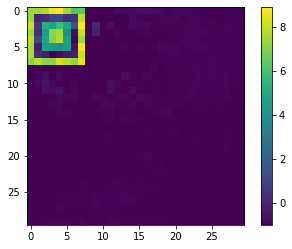

EPOCH 600: 0.000921640224987641
EPOCH 800: 0.0007432895436068065
EPOCH 1000: 0.0006285822673817165


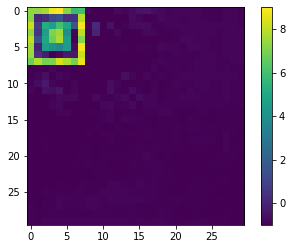

EPOCH 1200: 0.0005489105751621537
EPOCH 1400: 0.0004895583115285262


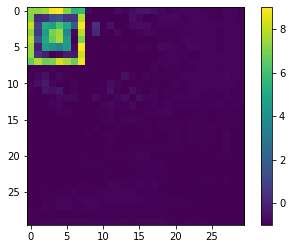

EPOCH 1600: 0.0004418417811393738
EPOCH 1800: 0.00040322387212654576
EPOCH 2000: 0.00037012457323726267


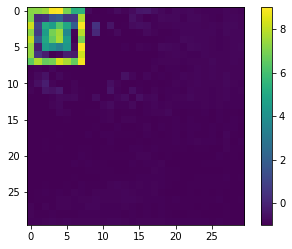

EPOCH 2200: 0.0003418275009607896
EPOCH 2400: 0.00031773565569892526


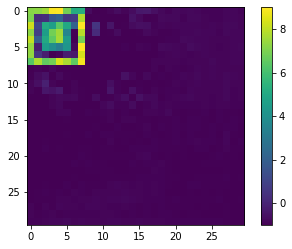

EPOCH 2600: 0.000297490867524175
EPOCH 2800: 0.0002801982445816975
EPOCH 3000: 0.00026532099582254887


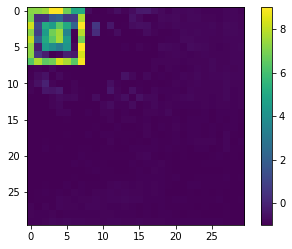

EPOCH 3200: 0.0002522030445106793
EPOCH 3400: 0.0002403374746791087


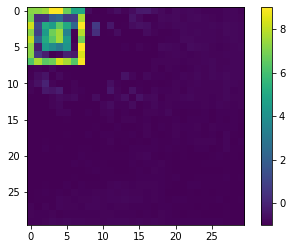

EPOCH 3600: 0.00022975406318437308
EPOCH 3800: 0.00022045271180104464
EPOCH 4000: 0.00021198621834628284


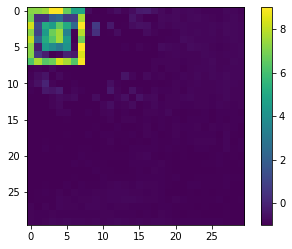

EPOCH 4200: 0.0002041756633843761
EPOCH 4400: 0.00019696140225278214


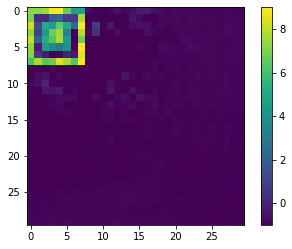

EPOCH 4600: 0.00019022421111003496
EPOCH 4800: 0.00018456022735335864
EPOCH 5000: 0.0001792838484107051


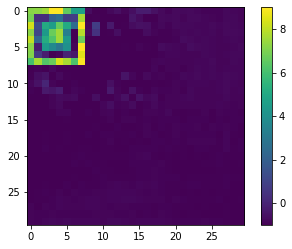

EPOCH 5200: 0.000174335393239744
EPOCH 5400: 0.00016968509225989692


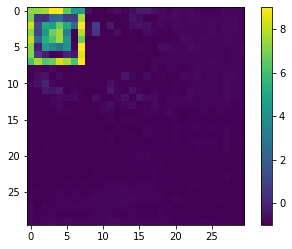

EPOCH 5600: 0.0001652136543270899
EPOCH 5800: 0.00016098073865578044
EPOCH 6000: 0.0001569863179611275


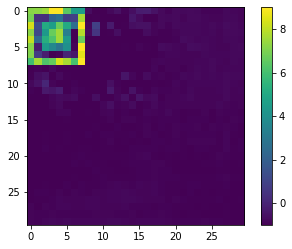

EPOCH 6200: 0.0001533496306365123
EPOCH 6400: 0.000150011042933329


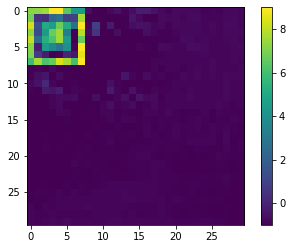

EPOCH 6600: 0.00014667246978206094
EPOCH 6800: 0.00014351277059176937
EPOCH 7000: 0.00014053192535357084


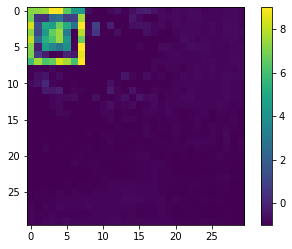

EPOCH 7200: 0.00013767033306066878
EPOCH 7400: 0.00013486837451637257


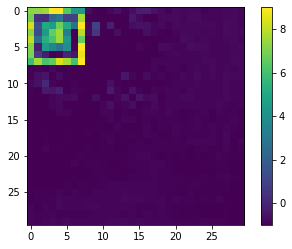

EPOCH 7600: 0.00013212603698775638
EPOCH 7800: 0.00012962217806489207
EPOCH 8000: 0.00012717794015770778


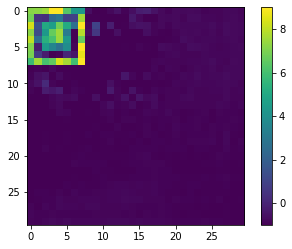

EPOCH 8200: 0.00012485293518693652
EPOCH 8400: 0.0001225875621457817


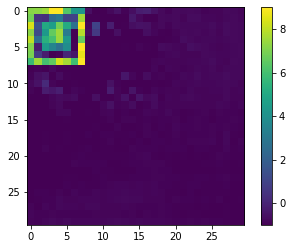

EPOCH 8600: 0.00012050104123773053
EPOCH 8800: 0.00011847412861243356
EPOCH 9000: 0.00011644723599602003


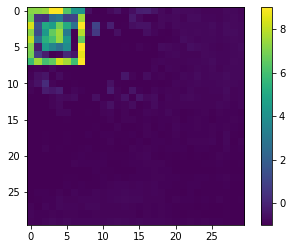

EPOCH 9200: 0.00011459918823675252
EPOCH 9400: 0.00011269153401372023


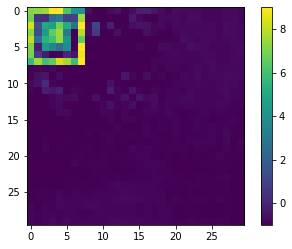

EPOCH 9600: 0.00011096272464783397
EPOCH 9800: 0.00010935314276139252
EPOCH 10000: 0.0001078031855286099


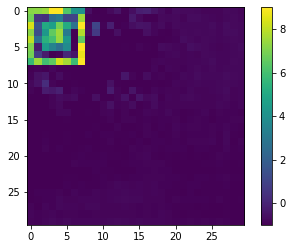

EPOCH 10200: 0.00010631284203554969
EPOCH 10400: 0.0001048523117788136


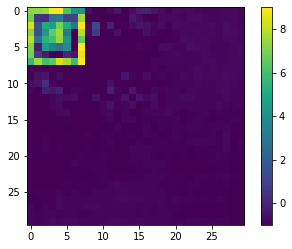

EPOCH 10600: 0.00010342158748244401
EPOCH 10800: 0.00010205048238276504
EPOCH 11000: 0.00010073899829876609


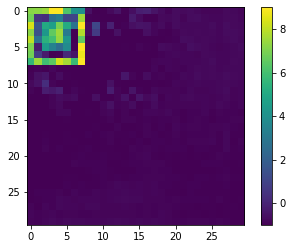

EPOCH 11200: 9.948711885954253e-05
EPOCH 11400: 9.823524487728719e-05


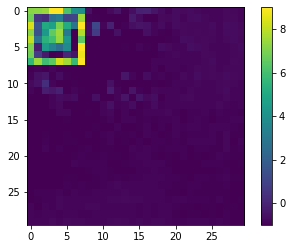

EPOCH 11600: 9.692376079328824e-05
EPOCH 11800: 9.579111974744592e-05
EPOCH 12000: 9.453925486013759e-05


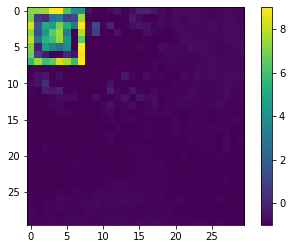

EPOCH 12200: 9.340661563328467e-05
EPOCH 12400: 9.227398004441056e-05


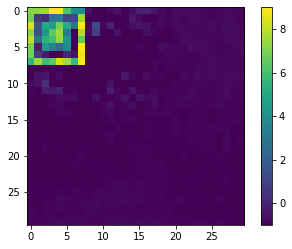

EPOCH 12600: 9.120096001424827e-05
EPOCH 12800: 9.012793270812836e-05
EPOCH 13000: 8.911453005566727e-05


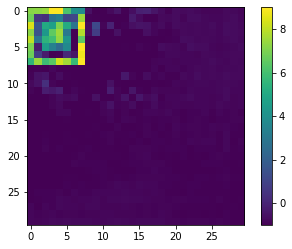

EPOCH 13200: 8.810112194623798e-05
EPOCH 13400: 8.714733303349931e-05


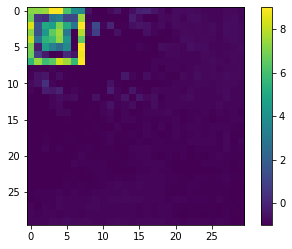

EPOCH 13600: 8.619354412076063e-05
EPOCH 13800: 8.535897359251976e-05
EPOCH 14000: 8.446479660051409e-05


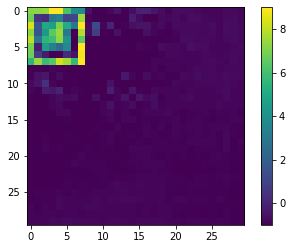

EPOCH 14200: 8.368984526896384e-05
EPOCH 14400: 8.285528019769117e-05


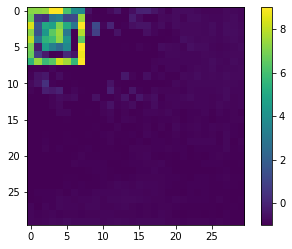

EPOCH 14600: 8.208032886614092e-05
EPOCH 14800: 8.130537753459066e-05
EPOCH 15000: 8.047081973927561e-05


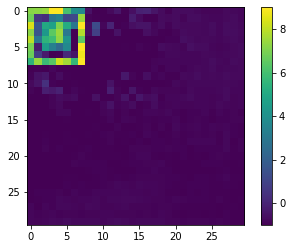

EPOCH 15200: 7.975548851391068e-05
EPOCH 15400: 7.904014910309343e-05


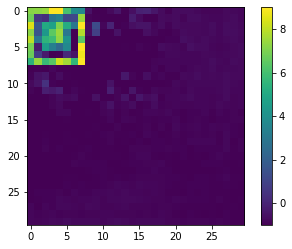

EPOCH 15600: 7.832480969227618e-05
EPOCH 15800: 7.760947755741654e-05
EPOCH 16000: 7.695375825278461e-05


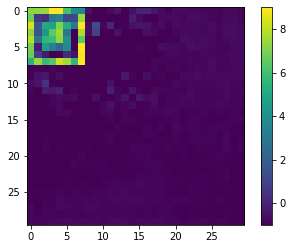

EPOCH 16200: 7.629803076270036e-05
EPOCH 16400: 7.564231054857373e-05


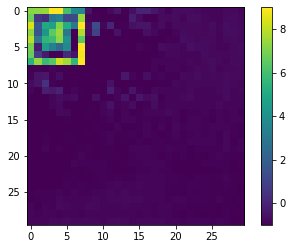

EPOCH 16600: 7.504620316467481e-05
EPOCH 16800: 7.439048295054818e-05
EPOCH 17000: 7.379437556664925e-05


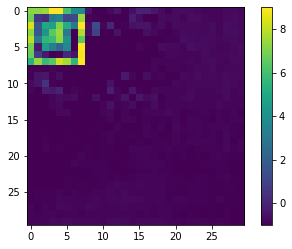

EPOCH 17200: 7.319826727325562e-05
EPOCH 17400: 7.26617699911003e-05


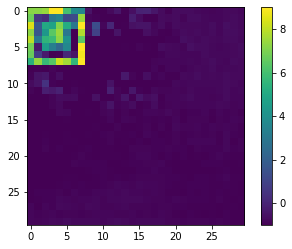

EPOCH 17600: 7.206566169770667e-05
EPOCH 17800: 7.152916987251956e-05
EPOCH 18000: 7.105227996362373e-05


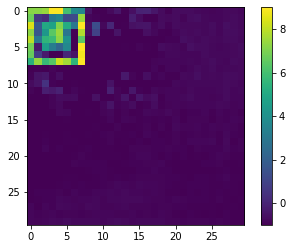

EPOCH 18200: 7.051578813843662e-05
EPOCH 18400: 7.00389018675196e-05


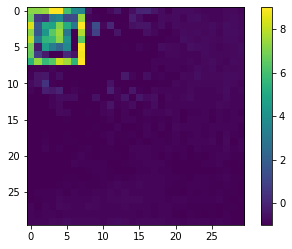

EPOCH 18600: 6.950241004233249e-05
EPOCH 18800: 6.902552377141546e-05
EPOCH 19000: 6.854864386696136e-05


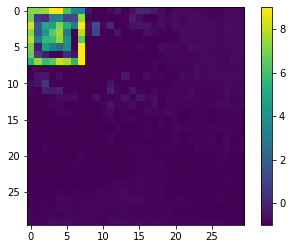

EPOCH 19200: 6.807175759604434e-05
EPOCH 19400: 6.759487769159023e-05


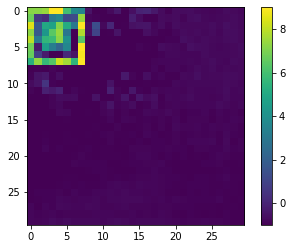

EPOCH 19600: 6.71179914206732e-05
EPOCH 19800: 6.66411151541979e-05
EPOCH 20000: 6.622384080401389e-05


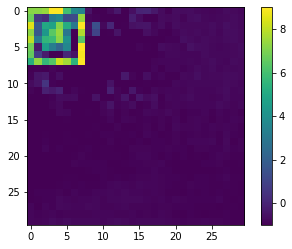

EPOCH 20200: 6.580656736332458e-05
EPOCH 20400: 6.544890857185237e-05


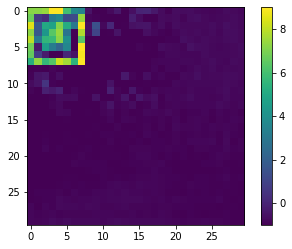

EPOCH 20600: 6.497202866739826e-05
EPOCH 20800: 6.455475886468776e-05
EPOCH 21000: 6.413748451450374e-05


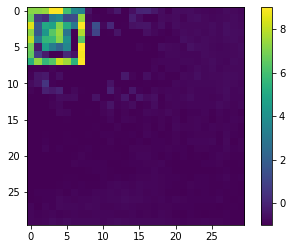

EPOCH 21200: 6.377982663252624e-05
EPOCH 21400: 6.330295036605094e-05


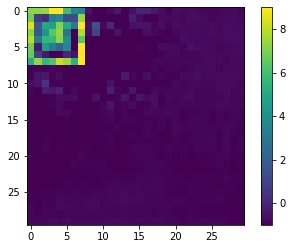

EPOCH 21600: 6.294528793659993e-05
EPOCH 21800: 6.252801813388942e-05
EPOCH 22000: 6.217035934241721e-05


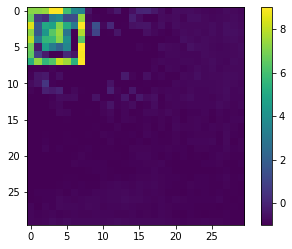

EPOCH 22200: 6.169348307594191e-05
EPOCH 22400: 6.13358215559856e-05


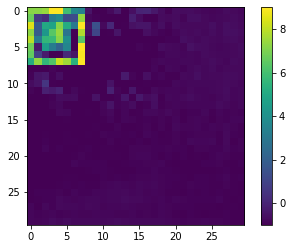

EPOCH 22600: 6.09781627645134e-05
EPOCH 22800: 6.06205048825359e-05
EPOCH 23000: 6.026284609106369e-05


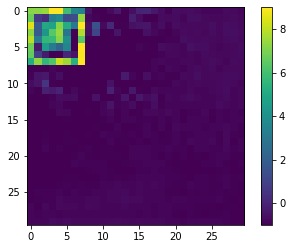

EPOCH 23200: 5.990518820908619e-05
EPOCH 23400: 5.954752941761399e-05


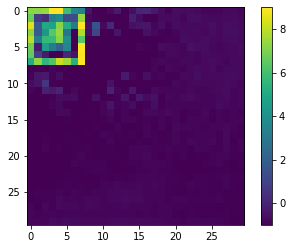

EPOCH 23600: 5.9189871535636485e-05
EPOCH 23800: 5.883221365365898e-05
EPOCH 24000: 5.853416678291978e-05


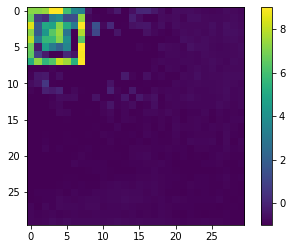

EPOCH 24200: 5.817650890094228e-05
EPOCH 24400: 5.781885010947008e-05


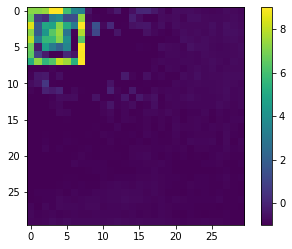

EPOCH 24600: 5.752080414822558e-05
EPOCH 24800: 5.722275818698108e-05
EPOCH 25000: 5.686509939550888e-05


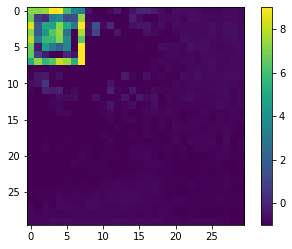

EPOCH 25200: 5.656705343426438e-05
EPOCH 25400: 5.6209399190265685e-05


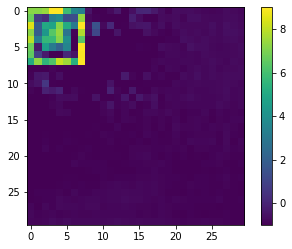

EPOCH 25600: 5.5911352319526486e-05
EPOCH 25800: 5.561330635828199e-05
EPOCH 26000: 5.531526039703749e-05


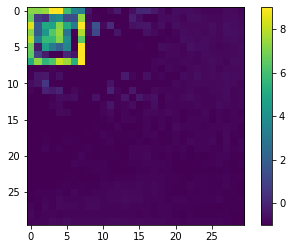

EPOCH 26200: 5.495760160556529e-05
EPOCH 26400: 5.465955564432079e-05


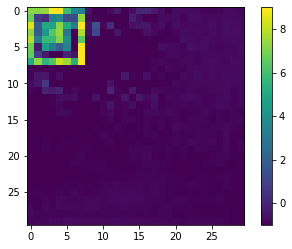

EPOCH 26600: 5.43615133210551e-05
EPOCH 26800: 5.40634664503159e-05
EPOCH 27000: 5.37654204890714e-05


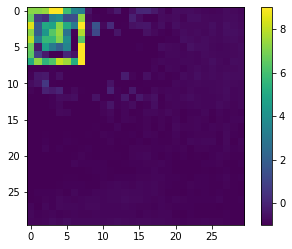

EPOCH 27200: 5.3467374527826905e-05
EPOCH 27400: 5.316932856658241e-05


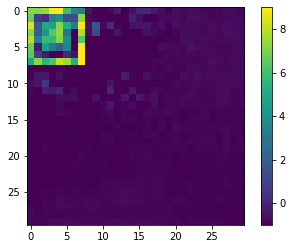

EPOCH 27600: 5.2871285333822016e-05
EPOCH 27800: 5.263284492684761e-05
EPOCH 28000: 5.239441088633612e-05


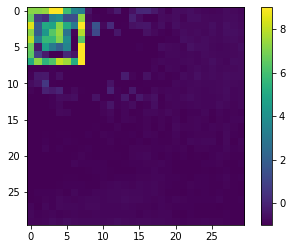

EPOCH 28200: 5.209636492509162e-05
EPOCH 28400: 5.179832260182593e-05


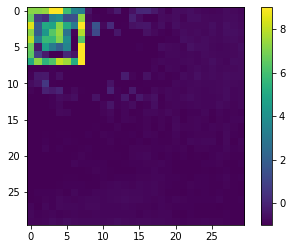

EPOCH 28600: 5.1559887651819736e-05
EPOCH 28800: 5.126184169057524e-05
EPOCH 29000: 5.102340492157964e-05


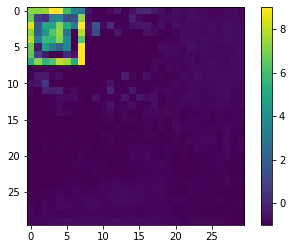

EPOCH 29200: 5.078496724308934e-05
EPOCH 29400: 5.054653320257785e-05


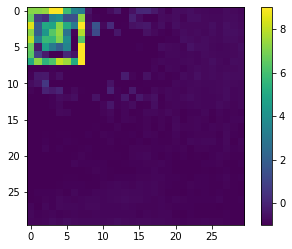

EPOCH 29600: 5.0248489969817456e-05
EPOCH 29800: 5.0069661483576056e-05
EPOCH 30000: 4.983122744306456e-05


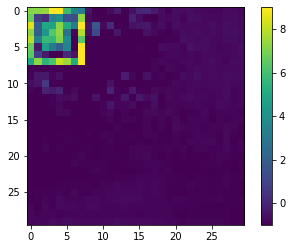

EPOCH 30200: 4.959279340255307e-05
EPOCH 30400: 4.941396491631167e-05


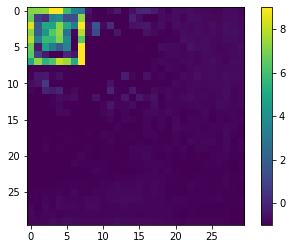

EPOCH 30600: 4.917553087580018e-05
EPOCH 30800: 4.8937096835288685e-05
EPOCH 31000: 4.8758268349047285e-05


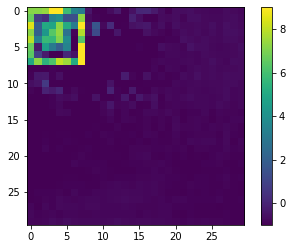

EPOCH 31200: 4.851983430853579e-05
EPOCH 31400: 4.82813993585296e-05


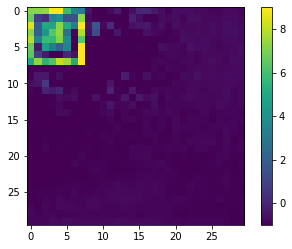

EPOCH 31600: 4.81025708722882e-05
EPOCH 31800: 4.786414046975551e-05
EPOCH 32000: 4.762570642924402e-05


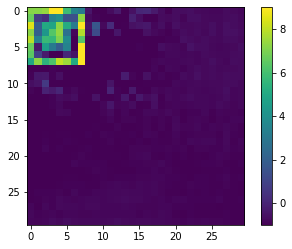

EPOCH 32200: 4.744687794300262e-05
EPOCH 32400: 4.7208443902491126e-05


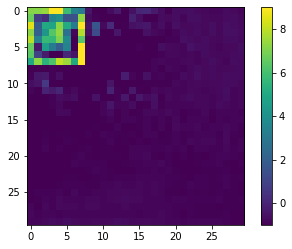

EPOCH 32600: 4.6970009861979634e-05
EPOCH 32800: 4.685079329647124e-05
EPOCH 33000: 4.6612359255959745e-05


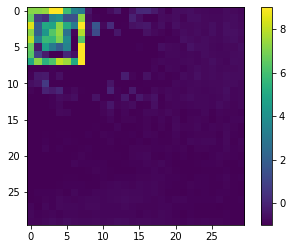

EPOCH 33200: 4.6433530769718345e-05
EPOCH 33400: 4.619510036718566e-05


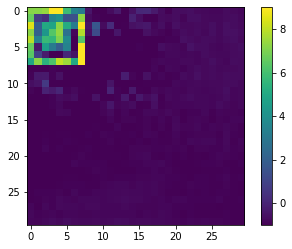

EPOCH 33600: 4.6016274609428365e-05
EPOCH 33800: 4.5837446123186965e-05
EPOCH 34000: 4.5658623093913775e-05


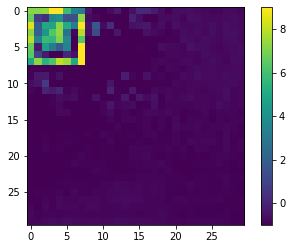

EPOCH 34200: 4.5479794607672375e-05
EPOCH 34400: 4.524136420513969e-05


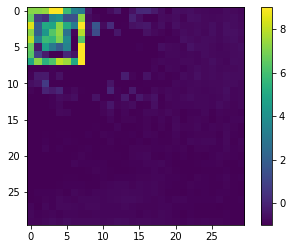

EPOCH 34600: 4.5062538447382394e-05
EPOCH 34800: 4.48837135991198e-05
EPOCH 35000: 4.4704887841362506e-05


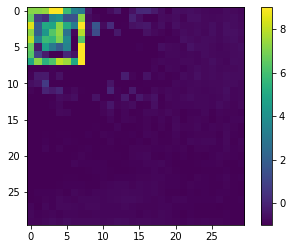

EPOCH 35200: 4.452606299309991e-05
EPOCH 35400: 4.434723723534262e-05


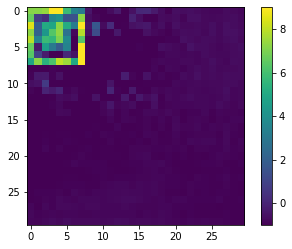

EPOCH 35600: 4.4168412387080025e-05
EPOCH 35800: 4.398958662932273e-05
EPOCH 36000: 4.381076450954424e-05


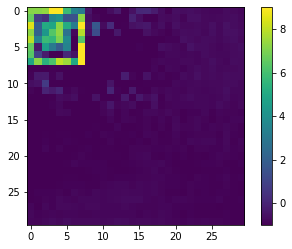

EPOCH 36200: 4.363193602330284e-05
EPOCH 36400: 4.3453113903524354e-05


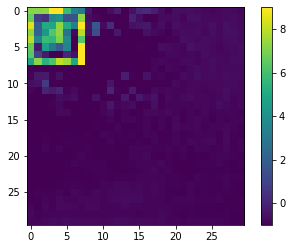

EPOCH 36600: 4.333389733801596e-05
EPOCH 36800: 4.3095463297504466e-05
EPOCH 37000: 4.297624673199607e-05


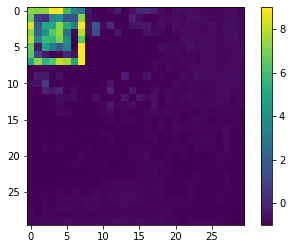

EPOCH 37200: 4.279742461221758e-05
EPOCH 37400: 4.261859612597618e-05


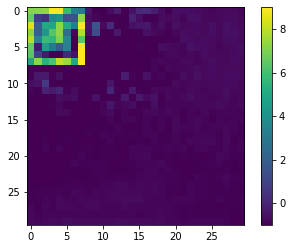

EPOCH 37600: 4.2439774006197695e-05
EPOCH 37800: 4.23205574406893e-05
EPOCH 38000: 4.2141731682932004e-05


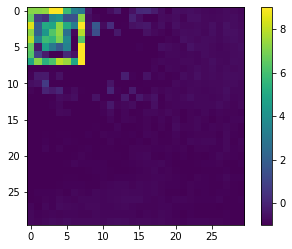

EPOCH 38200: 4.196290683466941e-05
EPOCH 38400: 4.178408471489092e-05


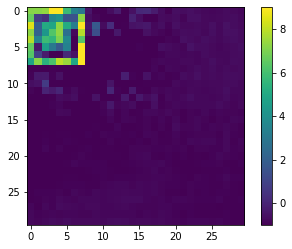

EPOCH 38600: 4.166486814938253e-05
EPOCH 38800: 4.148604239162523e-05
EPOCH 39000: 4.136682582611684e-05


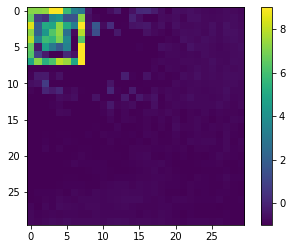

EPOCH 39200: 4.118800370633835e-05
EPOCH 39400: 4.1068787140829954e-05


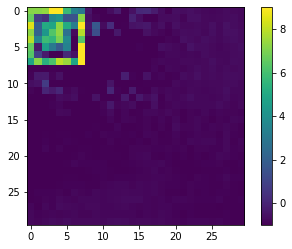

EPOCH 39600: 4.088996138307266e-05
EPOCH 39800: 4.0770744817564264e-05


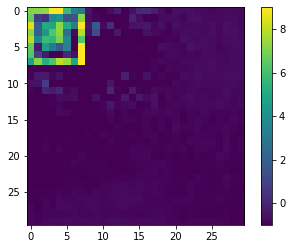

In [21]:
plt.imshow(Xt[n][0].reshape(60, 30))
plt.colorbar()
plt.show()
plt.imshow(Xt[n][1].reshape(60, 30))
plt.colorbar()
plt.show()
plt.imshow(Xt[n][2].reshape(60, 30))
plt.colorbar()
plt.show()
examples = [Xt[n][0].reshape(60,30,1).astype(np.float64), Xt[n][1].reshape(60,30,1).astype(np.float64)] 
cin = np.array([Xt[n][2].reshape(60,30,1)])
cin[0][30:, :, :] = cin[0][:30, :, :]
#cin[0][30:, :, :] = np.random.randint(-1, 10, size=(30, 30, 1))
#cin[0][30:, :, :] = np.zeros((30, 30, 1))
#sampletask[1][0][30:, :, :] = np.random.randint(-1, 11, size=(30, 30, 1))
plt.imshow(cin.reshape(60, 30))
plt.colorbar()
plt.show()
out = generateTask(examples, cin, 10, 40000, model)
plt.imshow(out)
plt.colorbar()
plt.show()